# MIDTERM: PARAMETER ESTIMATION

# Questions

In this homework, you will do a parameter estimation for
BioModels model 45.

1. (10 pts) **Acquire the Model**. Create a roadrunner instance of the model and print the antimony representation of the model in an output cell.

1. (20 pts) **Data Generation**. Create synthetic data for the floating species using the values of the parameter in the published model:
   1. (10 pts) Create 3 sets of synthetic data for standard deviations of 0.1, 0.2, and 0.5.
   1. (10 pts) Plot the three datatsets. What characteristics of the data confirm that these synthetic data
   are consistent with your expectations.
   
1. (50 pts) **Experiment Infrastructure**. Implement a ``doFit`` function that encapsulates the workflow that you'll use to evaluate fits on the 3 datasets you constructed in Question 1 that consider: (a) the starting point for fitting each parameter and (b) the range of parameter values.

   
1. (20 pts) **Experiment Execution and Analysis**.
Analyze the quality of fits obtained for the 3 different synthetic observation data.
The analysis should be conducted by setting the model parameters to 0 (variables in the "Variable initialization"
section of the model). Report the number of function evaluations and the quality of the
parameter estimates for the optimization algorithms differential_evolution and leastsquares for:
1. lower value of parameter = 0.5 its true value; 

**Please do your homework in a copy of this notebook, maintaining the sections.**

# Programming Preliminaries
This section provides the setup to run your python codes.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import SBstoat
import tellurium as te

## Constants

In [2]:
ENDTIME = 60
NUMPOINT = 1200
STDS = [0.1, 0.2, 0.5]

## Helper Functions

In [3]:
MODEL = """
A->B; A
B->; k*B; 
A = 10; 
B=0
k = 2
"""
MODEL_RR = te.loada(MODEL)
MODEL_ARR = MODEL_RR.simulate()

In [4]:
def arrToDF(arr):
    """
    Converts a NamedArray into a DataFrame.
    If it is simulation output, makes TIME the index.

    Parameters
    ----------
    arr: NamedArray
    
    Returns
    -------
    DataFrame
        Removes "[" , "]" from the names of species
    """
    columns = [c[1:-1] if c[0] == "[" else c for c in arr.colnames]
    df = pd.DataFrame(arr, columns=columns)
    df = df.set_index("time")
    return df

# Tests
assert(isinstance(arrToDF(MODEL_ARR), pd.DataFrame))
print("OK!")

OK!


In [5]:
MODEL_DF = arrToDF(MODEL_ARR)

In [6]:
# DELETE?
def fitModel(model, observedDF, parameterNames, testIdxs):
    """
    Fits the model parameters to the observed data.
    
    Parameters
    ----------
    model: str
        Antimony model or roadrunner
    observedDF: DataFrame
        Index: time
        Columns: floating species
    parameterNames: list-str
    testIdxs: list-int
        Indices in data that should be ignored in fitting since
        they will be used to evaluate test data
    
    Returns
    -------
    parameterDct
        key: parameterName
        value: parameterEstimate
    DataFrame - fitted values
        key: time
        columns: floating species     
    """
    indexArr = np.array(observedDF.index)
    endTime = max(observedDF.index)
    testIndices = indexArr[testIdxs]  # Elements in index that are test data
    newObservedDF = observedDF.copy()
    newObservedDF.loc[testIndices, :] = np.nan
    newObservedDF.index.name = C_TIME
    observedTS = SBstoat.NamedTimeseries(dataframe=newObservedDF)
    fitter = SBstoat.ModelFitter(model, observedTS,
                          parameterNames,
                          endTime=endTime,
                          numPoint=len(observedDF))
    fitter.fitModel()
    parameterDct = dict(fitter.params.valuesdict())
    #
    return parameterDct, fitter.fittedTS.to_dataframe()


# Question 1: Acquire the model

In [7]:
MODEL_RR = te.loadSBMLModel("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000045.2?filename=BIOMD0000000045_url.xml")
MODEL_ARR = MODEL_RR.simulate()
MODEL_ANT = MODEL_RR.getAntimony()
print(MODEL_ANT)

// Created by libAntimony v2.13.2
model *Goldbeter_Calcium_Oscillation_based_onCICR_AND_two_pool_model()

  // Compartments and Species:
  compartment extracellular, cytosol, intravesicular1, intravesicular2;
  species EC in extracellular, Z in cytosol, Y in intravesicular2, X in intravesicular1;

  // Reactions:
  vin: EC => Z; cytosol*(vin_v0 + vin_v1*beta);
  v2i: Z => Y; intravesicular2*v2i_Vm2i*Z^2/(v2i_K2i^2 + Z^2);
  v3i: Y => Z; cytosol*v3i_Vm3i*Y^2*Z^2/((v3i_K3y^2 + Y^2)*(v3i_K3z^2 + Z^2));
  v4: Y => Z; cytosol*v4_Kf*Y;
  v5: Z => EC; extracellular*v5_K*Z;
  v6: X => Z; cytosol*v6_Kf*X;
  v2s: Z => X; intravesicular1*v2s_Vm2s*Z^2/(v2s_K2s^2 + Z^2);
  v3s: X => Z; cytosol*beta*v3s_Vm3s*X^2/(v3s_K3s^2 + X^2);

  // Species initializations:
  EC = 0;
  Z = 0;
  Y = 0;
  X = 0.5;

  // Compartment initializations:
  extracellular = 1;
  cytosol = 1;
  intravesicular1 = 1;
  intravesicular2 = 1;

  // Variable initializations:
  beta = 1;
  vin_v0 = 0.015;
  vin_v1 = 0.012;
  v2i_

# Question 2: Data Generation

In [22]:
def generateNoisyData(std, model=MODEL_ANT, is_plot=True):
    """
    Generates noise columns in a dataframe.
    
    Parameters
    ----------
    std: float (standard deviation of generated noise)
    model: str (antimony model)
    is_plot: bool (plot the noise)
    
    Returns
    -------
    NamedTimeseries
    """
    rr = te.loada(model)
    data = rr.simulate()
    df = arrToDF(data)
    normalization_ser = df.mean()
    # Use the input DataFrame as a template
    noise_df = df.copy()
    # Create the noise data
    for column in noise_df.columns:
        noise_arr = np.random.normal(0, std, len(noise_df))
        noise_df[column] = normalization_ser.loc[column]*noise_arr 
    if is_plot:
        _, ax = plt.subplots(1)
        for column in noise_df.columns:
            ax.scatter(noise_df.index, noise_df[column])
        plt.legend(noise_df.columns)
        plt.title("Generated Noise. Std=%2.2f" % std)
    data_df = df + noise_df
    return SBstoat.NamedTimeseries(dataframe=data_df)
                  
# Tests
df = generateNoisyData(0.5, is_plot=False)
assert(isinstance(df, SBstoat.NamedTimeseries))
print("OK!")

OK!


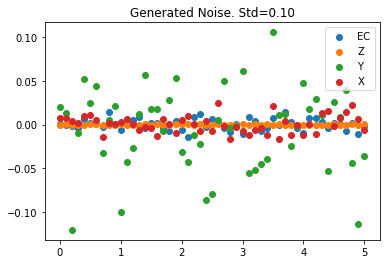

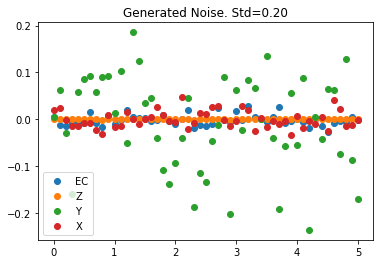

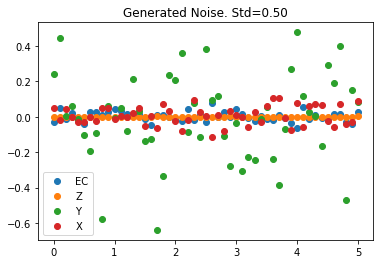

In [9]:
for std in STDS:
    generateNoisyData(std)

# Question 3: Experiment Instrumentation

In [10]:
# Dictionary representation of the parameters and their values
PARAMETER_DCT = {"beta": 1, "vin_v0": 0.015, "vin_v1": 0.012,
       "v2i_Vm2i": 3.1, "v2i_K2i": 0.005,
      "v3i_Vm3i": 25, "v3i_K3y": 0.065, "v3i_K3z": 0.022, "v4_Kf": 0.5,
       "v5_K": 1, "v6_Kf": 0.5, "v2s_Vm2s": 1.5, "v2s_K2s": 0.0265,
       "v3s_Vm3s": 0.169, "v3s_K3s": 0.1,
      }

def getParameters(parameter_dct=PARAMETER_DCT, lower_frc=1.0, value_frc=1.0, upper_frc=1.0):
    """
    Constructs the list of parameters for for the model.
    
    Parameters
    ----------
    parameter_dct: dict (key: name, value: parameter value)
    lower_frc: float (fraction used to calculate lower range of search. Should be in [0, 1.0])
    value_frc: float (fraction used to calculate start of search. lower_frc <= value_frc <= upper_frc)
    upper_frc: float (fraction used to calculate upper limit of search. Should be in [value_frc, inf])
    
    Returns
    -------
    list-SBstoat.Parameter
    """
    parameters = []
    for key, true_value in parameter_dct.items():
        lower = lower_frc*true_value
        value = value_frc*true_value
        upper = upper_frc*true_value
        parameter = SBstoat.Parameter(key, lower=lower, value=value, upper=upper)
        parameters.append(parameter)
    return parameters

# Tests
parameter_dct = {"k1": 1, "k2": 2}
parameters = getParameters(parameter_dct=parameter_dct, lower_frc=0.5, value_frc=0.8, upper_frc=2.0)
assert(len(parameters) == 2)
assert(isinstance(parameters[0], SBstoat.Parameter))
assert(parameters[0].lower == 0.5)
assert(parameters[0].value == 0.8)
assert(parameters[0].upper == 2.0)
print("OK!")

OK!


In [29]:
def doFit(model=MODEL_ANT,
          std=0.2,
          fitterMethods=["leastsq"], 
          lower_frc=0.5,
          value_frc=0.5,
          upper_frc=2.0,
          isReport=False):
    """
    Encapsulates the workflow to fit the linear pathway model.

    Parameters
    ----------
    selectedColumns: list-str
    endTime: int
    fitterMethods: list-str
    parametersToFit: list-SBstoat.Parameter
    isReport: bool
        Produce outputs

    Returns
    -------
    ModelFitter
    """
    parameters = getParameters(PARAMETER_DCT, lower_frc, value_frc, upper_frc)
    timeseries = generateNoisyData(std, model=model, is_plot=False)
    # Construct the fitter and do the fit
    fitter = SBstoat.ModelFitter(model, timeseries,
                         fitterMethods=fitterMethods, 
                         parametersToFit=parameters)
    fitter.fitModel()
    if isReport:
        print(fitter.reportFit())
        fitter.plotFitAll(figsize=(20, 5), numCol=5, color=["red", "blue"],
                          titlePosition=(0.5, 1.05))
    return fitter

# TESTS
result = doFit(isReport=False, std=0.2, fitterMethods=["leastsquares"],
              lower_frc=0.5, value_frc=0.5, upper_frc=2.0)
assert(isinstance(result, SBstoat.ModelFitter))
print("OK")

SyntaxError: keyword argument repeated (<ipython-input-29-a4601715e572>, line 39)

# Question 4: Experiment Execution and Analysis